In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from gpflow.kernels import Matern32, Kernel
from gpflow.models import GPR
from gpflow import set_trainable
from sklearn.preprocessing import StandardScaler
import vectorbt as vbt
from datetime import datetime, timedelta
import ruptures as rpt
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# Define the custom ChangePointKernel for Gaussian Process Regression
class ChangePointKernel(Kernel):
    def __init__(self, base_kernel, changepoints):
        super().__init__()
        self.base_kernel = base_kernel
        # changepoints: list of indices where a regime change is detected.
        self.changepoints = changepoints

    def get_region(self, X):
        cp = tf.constant(self.changepoints, dtype=X.dtype)
        regions = tf.searchsorted(cp, X[:, 0], side='right')
        return regions

    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        regions_X = self.get_region(X)
        regions_X2 = self.get_region(X2)
        regions_equal = tf.cast(tf.equal(tf.expand_dims(regions_X, 1), tf.expand_dims(regions_X2, 0)), X.dtype)
        base_cov = self.base_kernel.K(X, X2)
        return base_cov * regions_equal

    def K_diag(self, X):
        return self.base_kernel.K_diag(X)

def fetch_and_process_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    if data.empty:
        raise ValueError(f"No data found for {ticker} between {start_date} and {end_date}")
    # Prefer "Adj Close" if available, otherwise "Close"
    if "Adj Close" in data.columns:
        price_series = data["Adj Close"].copy()
    else:
        price_series = data["Close"].copy()
    if isinstance(price_series, pd.DataFrame):
        price_series = price_series.squeeze()
    price_series.name = ticker
    returns = price_series.pct_change().dropna()
    scaler = StandardScaler()
    std_returns = scaler.fit_transform(returns.values.reshape(-1, 1))
    valid_index = returns.index
    return price_series.loc[valid_index], pd.Series(
        std_returns.flatten(), index=valid_index, name="Standardized Returns"
    )

def detect_changepoints(returns, lookback_window):
    # Use ruptures to detect changepoints using an RBF model.
    algo = rpt.Pelt(model="rbf").fit(returns.values)
    # Use the lookback_window as penalty; this is a simplified proxy for CPD LBW.
    result = algo.predict(pen=lookback_window)
    return result

def generate_signals(returns, changepoints, train_ratio, epochs, 
                     dropout_rate, lstm_hidden_units, learning_rate, batch_size):
    # Use time index as a feature.
    X = np.arange(len(returns), dtype=np.float64).reshape(-1, 1)
    y = returns.values.reshape(-1, 1)
    # Use Gaussian Process Regression with the ChangePointKernel for trend extraction.
    base_kernel = Matern32()
    kernel = ChangePointKernel(base_kernel, changepoints)
    gpr = GPR(data=(X, y), kernel=kernel)
    set_trainable(gpr.likelihood.variance, False)
    trend = gpr.predict_f(X)[0].numpy().flatten()
    # Combine returns and trend to form a feature set.
    features = np.hstack([returns.values.reshape(-1, 1), trend.reshape(-1, 1)])
    split_index = int(len(features) * train_ratio)
    train_features = features[:split_index]
    train_labels = returns.values[:split_index]
    # Reshape features for LSTM input.
    train_features = train_features.reshape((train_features.shape[0], 1, train_features.shape[1]))
    # Build the LSTM model.
    model = Sequential([
        LSTM(lstm_hidden_units, return_sequences=True,
             input_shape=(train_features.shape[1], train_features.shape[2])),
        Dropout(dropout_rate),
        LSTM(int(lstm_hidden_units / 2)),
        Dense(1, activation="tanh")
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
    model.fit(train_features, train_labels, epochs=epochs, batch_size=batch_size, verbose=0)
    # Predict signals for all features.
    all_features = features.reshape((features.shape[0], 1, features.shape[1]))
    predicted_signals = model.predict(all_features, verbose=0).flatten()
    positions = np.clip(predicted_signals, -1, 1)
    return positions

def backtest_strategy(price_series, positions):
    if isinstance(price_series, pd.DataFrame):
        price_series = price_series.squeeze()
    positions = pd.Series(positions, index=price_series.index, name=price_series.name)
    entries = positions > 0
    exits = positions < 0
    pf = vbt.Portfolio.from_signals(
        close=price_series,
        entries=entries,
        exits=exits,
        size=np.abs(positions),
        freq="1D"
    )
    return pf

def compute_trade_statistics(pf, price_series):
    # Calculate benchmark return as buy-and-hold return
    benchmark_return = price_series.iloc[-1] / price_series.iloc[0] - 1
    
    # Extract trade records from the portfolio
    trades = pf.trades.records
    if trades.empty:
        win_rate = np.nan
        avg_win = np.nan
        avg_loss = np.nan
    else:
        # Assuming 'pnl' column exists representing profit (can be negative).
        wins = trades[trades.pnl > 0]
        losses = trades[trades.pnl < 0]
        win_rate = len(wins) / len(trades) if len(trades) > 0 else np.nan
        avg_win = wins.pnl.mean() if not wins.empty else np.nan
        avg_loss = losses.pnl.mean() if not losses.empty else np.nan
    return benchmark_return, win_rate, avg_win, avg_loss

def main():
    # Fixed hyperparameters.
    params = {
        'batch_size': 128,
        'dropout_rate': 0.2,
        'learning_rate': 0.001,
        'lookback_window': 21,
        'lstm_hidden_units': 40,
        'epochs': 50,
        'train_ratio': 0.8
    }
    
    # List of top 10 cryptocurrencies (excluding stablecoins).
    top_cryptos = [
        "BTC-USD",  # Bitcoin
        "ETH-USD",  # Ethereum
        "BNB-USD",  # Binance Coin
        "XRP-USD",  # XRP
        "ADA-USD",  # Cardano
        "SOL-USD",  # Solana
        "DOT-USD",  # Polkadot
        "DOGE-USD", # Dogecoin
        "AVAX-USD", # Avalanche
        "MATIC-USD" # Polygon (MATIC)
    ]

    # Define test periods.
    periods = []
    for year in range(2019, 2025):
        period_label = str(year)
        start_date = f"{year}-01-01"
        end_date = f"{year}-12-31"
        periods.append((period_label, start_date, end_date))
    # YTD 2025 using current date as provided in the session (2025-02-24).
    periods.append(("2025_YTD", "2025-01-01", "2025-02-24"))

    results = []
    
    # Loop over each cryptocurrency and each period.
    for crypto in top_cryptos:
        for period_label, start_date, end_date in periods:
            print(f"Processing {crypto} for period {period_label} ({start_date} to {end_date})")
            try:
                price_series, returns = fetch_and_process_data(crypto, start_date, end_date)
                if len(returns) < params['lookback_window']:
                    print(f"Not enough data for {crypto} in period {period_label}. Skipping.")
                    continue
                changepoints = detect_changepoints(returns, lookback_window=params['lookback_window'])
                positions = generate_signals(
                    returns, changepoints,
                    train_ratio=params['train_ratio'],
                    epochs=params['epochs'],
                    dropout_rate=params['dropout_rate'],
                    lstm_hidden_units=params['lstm_hidden_units'],
                    learning_rate=params['learning_rate'],
                    batch_size=params['batch_size']
                )
                portfolio = backtest_strategy(price_series, positions)
                total_return = float(portfolio.total_return())
                sharpe_ratio = float(portfolio.sharpe_ratio())
                max_drawdown = float(portfolio.max_drawdown())
                
                # Compute additional trade statistics.
                benchmark_return, win_rate, avg_win, avg_loss = compute_trade_statistics(portfolio, price_series)
                
                result = {
                    "crypto": crypto,
                    "period": period_label,
                    "start_date": start_date,
                    "end_date": end_date,
                    "total_return": total_return,
                    "sharpe_ratio": sharpe_ratio,
                    "max_drawdown": max_drawdown,
                    "benchmark_return": benchmark_return,
                    "win_rate": win_rate,
                    "avg_win": avg_win,
                    "avg_loss": avg_loss
                }
                results.append(result)
            except Exception as e:
                print(f"Error processing {crypto} for {period_label}: {e}")
    
    # Save all results into a DataFrame.
    results_df = pd.DataFrame(results)
    print("\nBacktest Results:")
    print(results_df)
    
    # Optionally, save the DataFrame to a CSV file.
    results_df.to_csv("crypto_backtest_results.csv", index=False)

if __name__ == "__main__":
    main()

Processing BTC-USD for period 2019 (2019-01-01 to 2019-12-31)
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing BTC-USD for period 2020 (2020-01-01 to 2020-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing BTC-USD for period 2021 (2021-01-01 to 2021-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing BTC-USD for period 2022 (2022-01-01 to 2022-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing BTC-USD for period 2023 (2023-01-01 to 2023-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing BTC-USD for period 2024 (2024-01-01 to 2024-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing BTC-USD for period 2025_YTD (2025-01-01 to 2025-02-24)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing ETH-USD for period 2019 (2019-01-01 to 2019-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Processing ETH-USD for period 2020 (2020-01-01 to 2020-12-31)


[*********************100%***********************]  1 of 1 completed
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing ETH-USD for period 2021 (2021-01-01 to 2021-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing ETH-USD for period 2022 (2022-01-01 to 2022-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing ETH-USD for period 2023 (2023-01-01 to 2023-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing ETH-USD for period 2024 (2024-01-01 to 2024-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing ETH-USD for period 2025_YTD (2025-01-01 to 2025-02-24)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing BNB-USD for period 2019 (2019-01-01 to 2019-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Processing BNB-USD for period 2020 (2020-01-01 to 2020-12-31)


[*********************100%***********************]  1 of 1 completed
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing BNB-USD for period 2021 (2021-01-01 to 2021-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing BNB-USD for period 2022 (2022-01-01 to 2022-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing BNB-USD for period 2023 (2023-01-01 to 2023-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing BNB-USD for period 2024 (2024-01-01 to 2024-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing BNB-USD for period 2025_YTD (2025-01-01 to 2025-02-24)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing XRP-USD for period 2019 (2019-01-01 to 2019-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing XRP-USD for period 2020 (2020-01-01 to 2020-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing XRP-USD for period 2021 (2021-01-01 to 2021-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing XRP-USD for period 2022 (2022-01-01 to 2022-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing XRP-USD for period 2023 (2023-01-01 to 2023-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing XRP-USD for period 2024 (2024-01-01 to 2024-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing XRP-USD for period 2025_YTD (2025-01-01 to 2025-02-24)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing ADA-USD for period 2019 (2019-01-01 to 2019-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing ADA-USD for period 2020 (2020-01-01 to 2020-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing ADA-USD for period 2021 (2021-01-01 to 2021-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing ADA-USD for period 2022 (2022-01-01 to 2022-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing ADA-USD for period 2023 (2023-01-01 to 2023-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing ADA-USD for period 2024 (2024-01-01 to 2024-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing ADA-USD for period 2025_YTD (2025-01-01 to 2025-02-24)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Processing SOL-USD for period 2019 (2019-01-01 to 2019-12-31)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SOL-USD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2019-01-01 -> 2019-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1546300800, endDate = 1577750400")')
[*********************100%***********************]  1 of 1 completed

Error processing SOL-USD for 2019: No data found for SOL-USD between 2019-01-01 and 2019-12-31
Processing SOL-USD for period 2020 (2020-01-01 to 2020-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing SOL-USD for period 2021 (2021-01-01 to 2021-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing SOL-USD for period 2022 (2022-01-01 to 2022-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing SOL-USD for period 2023 (2023-01-01 to 2023-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing SOL-USD for period 2024 (2024-01-01 to 2024-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing SOL-USD for period 2025_YTD (2025-01-01 to 2025-02-24)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Processing DOT-USD for period 2019 (2019-01-01 to 2019-12-31)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DOT-USD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2019-01-01 -> 2019-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1546300800, endDate = 1577750400")')
[*********************100%***********************]  1 of 1 completed


Error processing DOT-USD for 2019: No data found for DOT-USD between 2019-01-01 and 2019-12-31
Processing DOT-USD for period 2020 (2020-01-01 to 2020-12-31)


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing DOT-USD for period 2021 (2021-01-01 to 2021-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing DOT-USD for period 2022 (2022-01-01 to 2022-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing DOT-USD for period 2023 (2023-01-01 to 2023-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing DOT-USD for period 2024 (2024-01-01 to 2024-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing DOT-USD for period 2025_YTD (2025-01-01 to 2025-02-24)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing DOGE-USD for period 2019 (2019-01-01 to 2019-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing DOGE-USD for period 2020 (2020-01-01 to 2020-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing DOGE-USD for period 2021 (2021-01-01 to 2021-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing DOGE-USD for period 2022 (2022-01-01 to 2022-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing DOGE-USD for period 2023 (2023-01-01 to 2023-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing DOGE-USD for period 2024 (2024-01-01 to 2024-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing DOGE-USD for period 2025_YTD (2025-01-01 to 2025-02-24)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Processing AVAX-USD for period 2019 (2019-01-01 to 2019-12-31)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AVAX-USD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2019-01-01 -> 2019-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1546300800, endDate = 1577750400")')
[*********************100%***********************]  1 of 1 completed
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Error processing AVAX-USD for 2019: No data found for AVAX-USD between 2019-01-01 and 2019-12-31
Processing AVAX-USD for period 2020 (2020-01-01 to 2020-12-31)


[*********************100%***********************]  1 of 1 completed

Processing AVAX-USD for period 2021 (2021-01-01 to 2021-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing AVAX-USD for period 2022 (2022-01-01 to 2022-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing AVAX-USD for period 2023 (2023-01-01 to 2023-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing AVAX-USD for period 2024 (2024-01-01 to 2024-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing AVAX-USD for period 2025_YTD (2025-01-01 to 2025-02-24)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing MATIC-USD for period 2019 (2019-01-01 to 2019-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing MATIC-USD for period 2020 (2020-01-01 to 2020-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing MATIC-USD for period 2021 (2021-01-01 to 2021-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing MATIC-USD for period 2022 (2022-01-01 to 2022-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing MATIC-USD for period 2023 (2023-01-01 to 2023-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing MATIC-USD for period 2024 (2024-01-01 to 2024-12-31)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[*********************100%***********************]  1 of 1 completed

Processing MATIC-USD for period 2025_YTD (2025-01-01 to 2025-02-24)



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Backtest Results:
       crypto    period  start_date    end_date  total_return  sharpe_ratio  \
0     BTC-USD      2019  2019-01-01  2019-12-31      1.099082      1.800732   
1     BTC-USD      2020  2020-01-01  2020-12-31      1.629214      2.440952   
2     BTC-USD      2021  2021-01-01  2021-12-31      0.740051      1.394784   
3     BTC-USD      2022  2022-01-01  2022-12-31     -0.201682     -0.356170   
4     BTC-USD      2023  2023-01-01  2023-12-31      1.168739      2.452002   
..        ...       ...         ...         ...           ...           ...   
62  MATIC-USD      2021  2021-01-01  2021-12-31      0.004056      0.525955   
63  MATIC-USD      2022  2022-01-01  2022-12-31     -0.007413     -1.508825   
64  MATIC-USD      2023  2023-01-01  2023-12-31      0.001720      0.533841   
65  MATIC-USD      2024  2024-01-01  2024-12-31     -0.001371     -0.551067   
66  MATIC-USD  2025_YTD  2025-01-01  2025-02-24     -0.000102     -1.822701   

    max_drawdown  benchmark_retu

In [3]:
df = pd.read_csv("crypto_backtest_results.csv")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df

,crypto,period,start_date,end_date,total_return,sharpe_ratio,max_drawdown,benchmark_return,win_rate,avg_win,avg_loss
0,BTC-USD,2019,2019-01-01,2019-12-31,1.099082,1.800732,-0.217843,0.849414,0.365854,8.710087,-2.911431
1,BTC-USD,2020,2020-01-01,2020-12-31,1.629214,2.440952,-0.251269,3.128706,0.462366,6.509735,-2.339945
2,BTC-USD,2021,2021-01-01,2021-12-31,0.740051,1.394784,-0.281501,0.468476,0.375000,7.682201,-3.324213
3,BTC-USD,2022,2022-01-01,2022-12-31,-0.201682,-0.356170,-0.373900,-0.649329,0.369048,3.161539,-2.229734
4,BTC-USD,2023,2023-01-01,2023-12-31,1.168739,2.452002,-0.132852,1.526109,0.417582,6.134644,-2.193257
5,BTC-USD,2024,2024-01-01,2024-12-31,0.658705,1.614631,-0.218041,1.060663,0.369565,6.064911,-2.419595
6,BTC-USD,2025_YTD,2025-01-01,2025-02-24,-0.002594,0.105670,-0.102307,-0.006326,0.363636,2.321338,-1.363540
7,ETH-USD,2019,2019-01-01,2019-12-31,0.026079,0.260372,-0.221740,-0.144563,0.311828,3.380923,-1.491232
8,ETH-USD,2020,2020-01-01,2020-12-31,2.821991,3.181217,-0.190985,4.899207,0.500000,9.640929,-3.078159
9,ETH-USD,2021,2021-01-01,2021-12-31,1.285396,1.543410,-0.475342,3.794944,0.397849,14.090949,-7.142283


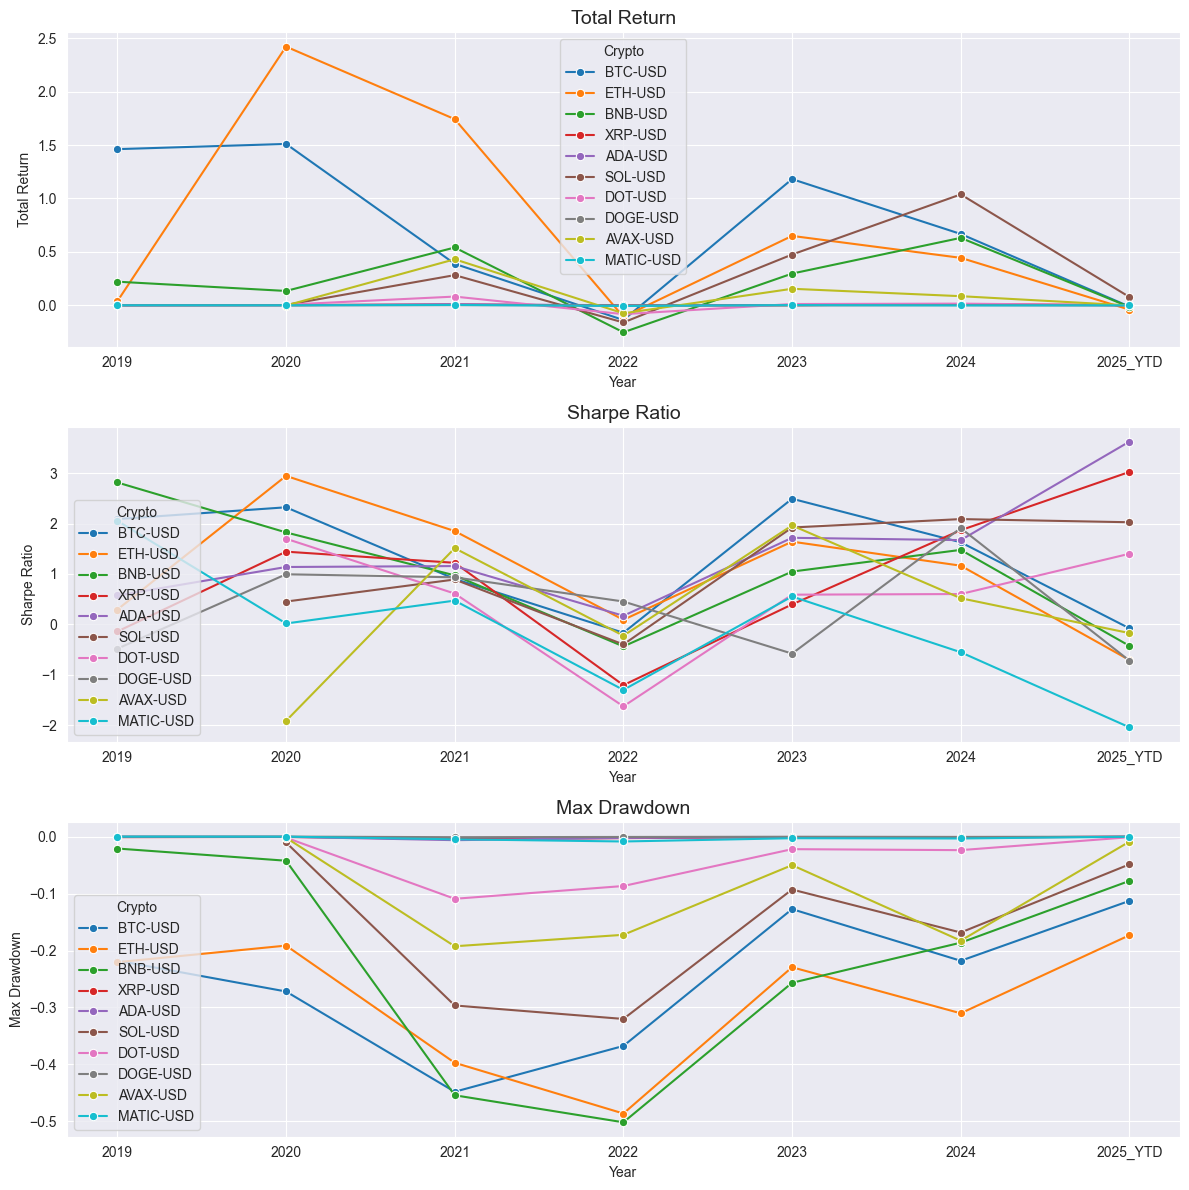

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df["period"] = df["period"].astype(str)

# Define metrics to plot
metrics = ["total_return", "sharpe_ratio", "max_drawdown"]
titles = ["Total Return", "Sharpe Ratio", "Max Drawdown"]

# Set the style
sns.set_style("darkgrid")

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.lineplot(data=df, x="period", y=metric, hue="crypto", marker="o", ax=ax)
    ax.set_title(titles[i], fontsize=14)
    ax.set_xlabel("Year")
    ax.set_ylabel(metric.replace("_", " ").title())
    ax.legend(title="Crypto")

# Adjust layout and show plot
plt.tight_layout()
plt.show()


Cumulative Returns (Readable Format):
crypto
ADA-USD       0.0000000000
AVAX-USD     -0.0000000007
BNB-USD       0.0000115957
BTC-USD       0.0010815849
DOGE-USD     -0.0000000000
DOT-USD      -0.0000000000
ETH-USD       0.0002038012
MATIC-USD    -0.0000000000
SOL-USD      -0.0000068687
XRP-USD       0.0000000000


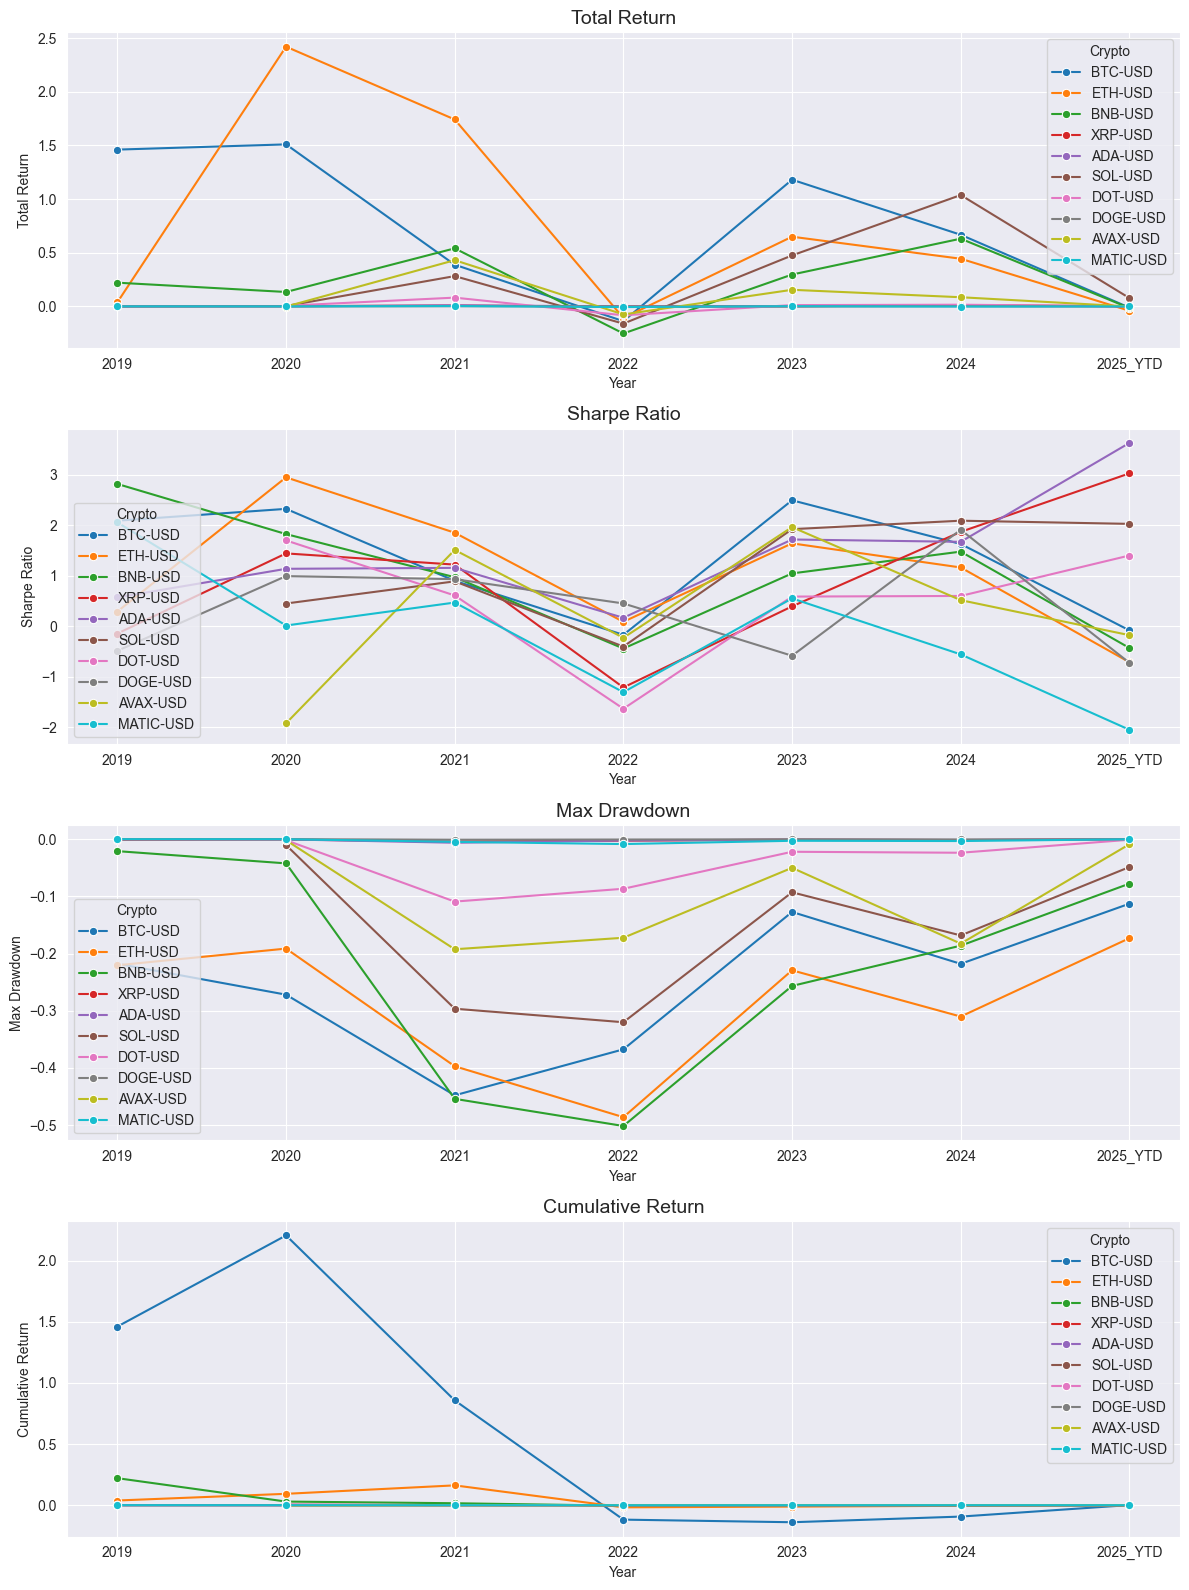

In [7]:
df["cumulative_return"] = df.groupby("crypto")["total_return"].cumprod()

# Print cumulative returns
cumulative_returns = df.groupby("crypto")["cumulative_return"].last()
# Format cumulative returns for readability
formatted_cumulative_returns = cumulative_returns.apply(lambda x: f"{x:,.10f}")

# Print nicely formatted results
print("\nCumulative Returns (Readable Format):")
print(formatted_cumulative_returns.to_string())
# Define metrics to plot
metrics = ["total_return", "sharpe_ratio", "max_drawdown", "cumulative_return"]
titles = ["Total Return", "Sharpe Ratio", "Max Drawdown", "Cumulative Return"]

# Set the style
sns.set_style("darkgrid")

# Create subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 16))

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.lineplot(data=df, x="period", y=metric, hue="crypto", marker="o", ax=ax)
    ax.set_title(titles[i], fontsize=14)
    ax.set_xlabel("Year")
    ax.set_ylabel(metric.replace("_", " ").title())
    ax.legend(title="Crypto")

# Adjust layout and show plot
plt.tight_layout()
plt.show()